In [1]:
import numpy as np
from urllib.request import urlopen
import libgp

In [2]:
url = "https://scrippsco2.ucsd.edu/assets/data/atmospheric/stations/in_situ_co2/monthly/monthly_in_situ_co2_mlo.csv"
# Load the data from URL
with urlopen(url) as response:
    # Skip header rows and load data
    lines = [line.decode('utf-8') for line in response.readlines()[66:]]
    data = np.genfromtxt(
        lines,
        delimiter=',',
        usecols=(0, 1, 4),  # Year, Month and CO2 concentration columns
    )

# Remove any rows with NaN values
data = data[data[:, 2] > 0]

print(f"Loaded {len(data)} measurements")
print("First few rows (Year, Month, CO2 concentration):")
print(data[:5])

Loaded 800 measurements
First few rows (Year, Month, CO2 concentration):
[[1958.      3.    315.71]
 [1958.      4.    317.45]
 [1958.      5.    317.51]
 [1958.      7.    315.87]
 [1958.      8.    314.93]]


In [3]:
date = data[:, 0] + data[:, 1] / 12.0
co2_levels = data[:, 2]
# Normalize the CO2 levels
mu_co2 = np.mean(co2_levels)
sigma_co2 = np.std(co2_levels)
co2_levels = (co2_levels - mu_co2) / sigma_co2

In [4]:
split = int(len(date) * 0.8)
X_train = date[:split]
y_train = co2_levels[:split]
X_test = date[split:]
y_test = co2_levels[split:]

In [5]:
kernel = "CovSum(CovSum(CovSEiso, CovRQiso), CovSum(CovPeriodic, CovNoise))"
# kernel = "CovSum(CovSEiso, CovNoise)"
gp = libgp.GaussianProcess(input_dim=1, covariance_function=kernel)
gp.set_loghyper(np.log(np.array([100, 2500, 1.0, 1.0, 1.0,100.0, 2.0, 1, 0.1])))  # Initial hyperparameters
gp.add_patterns(X_train, y_train)


In [6]:
optimizer = libgp.OptimizerRProp()
optimizer.maximize(gp, 200, verbose=False)

In [7]:
np.exp(gp.get_loghyper())

array([1.06626857e+02, 4.26552281e+00, 1.24629913e+00, 8.42261813e-02,
       6.07448693e-03, 1.27552790e+00, 8.47923838e-02, 1.00000000e+00,
       5.80966683e-03])

In [8]:
mu_train, sig2_train = gp.predict_with_variance(X_train)
mu_test, sig2_test = gp.predict_with_variance(X_test)

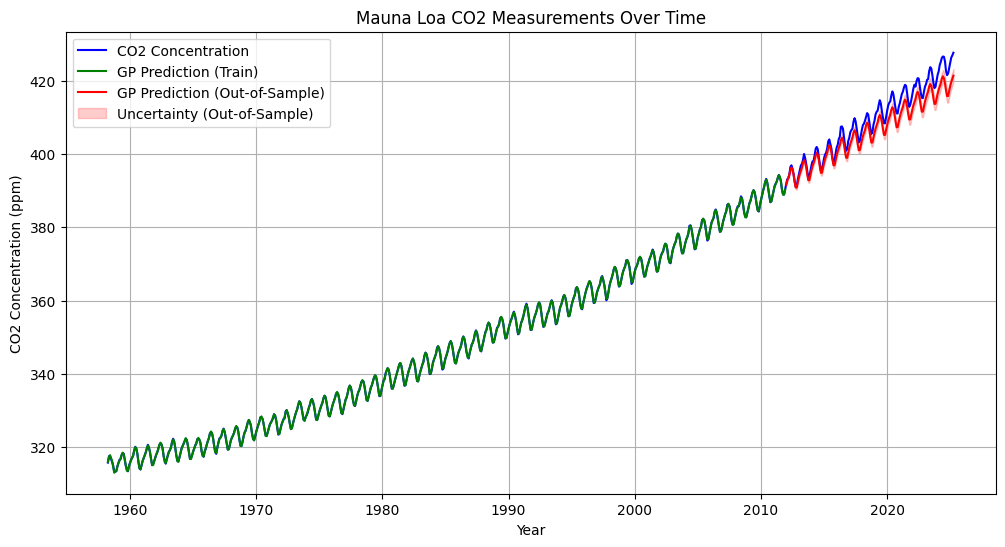

In [9]:
import matplotlib.pyplot as plt

mu_train_orig_scaled = mu_train * sigma_co2 + mu_co2
mu_test_orig_scaled = mu_test * sigma_co2 + mu_co2
sig2_train_orig_scaled = sig2_train * sigma_co2**2
sig2_test_orig_scaled = sig2_test * sigma_co2**2
co2_levels_orig_scaled = co2_levels * sigma_co2 + mu_co2

# Create the plot
plt.figure(figsize=(12, 6))
plt.plot(date, co2_levels_orig_scaled, 'b-', label='CO2 Concentration')
plt.plot(X_train, mu_train_orig_scaled, 'g-', label='GP Prediction (Train)')
plt.plot(X_test, mu_test_orig_scaled, 'r-', label='GP Prediction (Out-of-Sample)')
plt.fill_between(X_test, 
                 mu_test_orig_scaled - np.sqrt(sig2_test_orig_scaled), 
                 mu_test_orig_scaled + np.sqrt(sig2_test_orig_scaled), 
                 color='r', alpha=0.2, label='Uncertainty (Out-of-Sample)')
plt.xlabel('Year')
plt.ylabel('CO2 Concentration (ppm)')
plt.title('Mauna Loa CO2 Measurements Over Time')
plt.grid(True)
plt.legend()
plt.show()